In [1]:
# ECE 661 hw10 - Face Recognition
# Author: Ran Xu (xu943@purdue.edu)
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
def TrickyEigen(M, p=-1, FromTop=True): # (N, P) N>>P
    if(M.shape[0]>M.shape[1]):
        # Compute eigen of M^T * M instead of M * M^T
        A = np.dot(np.transpose(M), M)
        lamda, U = np.linalg.eig(A)
        V = np.dot(M, U)
        StdV = np.sqrt(np.sum(V**2, axis = 0, keepdims = True))
        NormV = V/StdV
    else:
        A = np.dot(M, np.transpose(M))
        lamda, NormV = np.linalg.eig(A)       
    if p == -1:
        p = min(M.shape[0], M.shape[1])
    if FromTop:
        return NormV[:, 0:p], lamda[0:p]
    else:
        return NormV[:, -p-1:-1], lamda[-p-1:-1]

In [2]:
TrainingFiles, TestFiles = ([], [])
for IdxPerson in range(1,31):
    for IdxPhoto in range(1,22):
        TrainingFiles.append("ECE661_2018_hw10_DB1/train/%02d_%02d.png" 
                             %(IdxPerson, IdxPhoto))
        TestFiles.append("ECE661_2018_hw10_DB1/test/%02d_%02d.png" 
                         %(IdxPerson, IdxPhoto))

In [3]:
# Face Recognition with PCA
# Load training images
ims = [cv.imread(x, cv.IMREAD_GRAYSCALE).reshape(-1,1) for x in TrainingFiles]
OriX = np.hstack(ims)
MeanX = np.mean(OriX, axis = 1, keepdims = True)     #(49152,1)
StdX = np.std(OriX-MeanX, axis = 0, keepdims = True) #(1,630)
NormX = (OriX-MeanX)/StdX
# Load test images
ims = [cv.imread(x, cv.IMREAD_GRAYSCALE).reshape(-1,1) for x in TestFiles]
TestOriX = np.hstack(ims)
TestNormX = (TestOriX-MeanX)/StdX

PCA_Accuracy = np.zeros((31,))
for p in range(1,31):
    # Compute top-p eigen vectors
    NormV, _ = TrickyEigen(NormX, p=p)
    # Do PCA on training images
    NormX_PCA = np.dot(np.transpose(NormV), NormX); # (p, 630)
    # Do PCA on test images
    TestNormX_PCA = np.dot(np.transpose(NormV), TestNormX); # (p, 630)
    # Matching    
    Correct = np.zeros((630,))
    for IdxTestImg in range(0,630):
        Score = [np.sum((TestNormX_PCA[:,IdxTestImg]-NormX_PCA[:,IdxTr])**2) 
                 for IdxTr in range(630)]
        NearestNeighbor = np.argmin(Score)
        Correct[IdxTestImg] = (int(IdxTestImg/21)==int(NearestNeighbor/21))
    PCA_Accuracy[p] = np.sum(Correct)/630
    print("(%d, %.2f%%)" %(p, PCA_Accuracy[p]*100), end = ", ")

(1, 13.02%), (2, 56.51%), (3, 82.70%), (4, 90.79%), (5, 94.29%), (6, 96.03%), (7, 98.10%), (8, 98.41%), (9, 99.37%), (10, 99.37%), (11, 99.21%), (12, 99.52%), (13, 99.68%), (14, 99.84%), (15, 99.84%), (16, 99.84%), (17, 99.84%), (18, 99.84%), (19, 100.00%), (20, 100.00%), (21, 100.00%), (22, 100.00%), (23, 100.00%), (24, 100.00%), (25, 100.00%), (26, 100.00%), (27, 100.00%), (28, 100.00%), (29, 100.00%), (30, 100.00%), 

In [4]:
# Face Recognition with LDA
# Load training images
ims = [cv.imread(x, cv.IMREAD_GRAYSCALE).reshape(-1,1) for x in TrainingFiles]
OriX = np.hstack(ims)
# Load test images
ims = [cv.imread(x, cv.IMREAD_GRAYSCALE).reshape(-1,1) for x in TestFiles]
TestOriX = np.hstack(ims)

# First step: Compute S_b and diagonalize it with trick
M = np.zeros((OriX.shape[0], 30))   # Sb = M*M^T
MeanX = np.mean(OriX, axis = 1, keepdims = True)     # (N,1)
for x in range(30): # 30 classes   
    MeanX_In = np.mean(OriX[:, x*21:x*21+21], axis = 1, keepdims = True) #(N,1)
    M[:, x:x+1] = MeanX_In - MeanX 
V, lamda = TrickyEigen(M)  # lamda is actually  
Z = np.dot(V, np.sqrt(np.diag(1/lamda)))  # (N, 30)

# Second step: Compute Z^T*Sw*Z and diagonalize it with trick
M = np.zeros(OriX.shape)   # Sw = M*M^T
for x in range(30): # 30 classes   
    MeanX_In = np.mean(OriX[:, x*21:x*21+21], axis = 1, keepdims = True) #(N,1)
    for y in range(21):
        Index = x*21 + y
        M[:, Index:Index+1] = OriX[:, Index:Index+1] - MeanX_In 
M2 = np.dot(np.transpose(Z), M)  # (Z^T * M) * (Z^T * M)^T 

LDA_Accuracy = np.zeros((31,))
for p in range(1, 31):
    # Compute top-p eigen vectors
    U, lamda = TrickyEigen(M2, p=p, FromTop=False)  # lamda is actually  
    A = np.dot(Z, U)
    A = np.dot(A, np.sqrt(np.diag(1/lamda)))    
    # Do LDA on training images
    OriX_LDA = np.dot(np.transpose(A), OriX); # (p, 630)
    # Do LDA on test images
    TestOriX_LDA = np.dot(np.transpose(A), TestOriX); # (p, 630)
    # Matching    
    Correct = np.zeros((630,))
    for IdxTestImg in range(0,630):
        Score = [np.sum((TestOriX_LDA[:,IdxTestImg]-OriX_LDA[:,IdxTr])**2) 
                 for IdxTr in range(630)]
        NearestNeighbor = np.argmin(Score)
        Correct[IdxTestImg] = (int(IdxTestImg/21)==int(NearestNeighbor/21))
    LDA_Accuracy[p] = np.sum(Correct)/630
    print("(%d, %.2f%%)" %(p, LDA_Accuracy[p]*100), end = ", ")

(1, 24.13%), (2, 78.57%), (3, 95.40%), (4, 98.41%), (5, 99.37%), (6, 99.84%), (7, 100.00%), (8, 100.00%), (9, 99.84%), (10, 99.84%), (11, 100.00%), (12, 99.84%), (13, 100.00%), (14, 100.00%), (15, 100.00%), (16, 100.00%), (17, 100.00%), (18, 100.00%), (19, 100.00%), (20, 100.00%), (21, 100.00%), (22, 100.00%), (23, 100.00%), (24, 100.00%), (25, 100.00%), (26, 100.00%), (27, 100.00%), (28, 100.00%), (29, 100.00%), (30, 100.00%), 

/home/ran/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


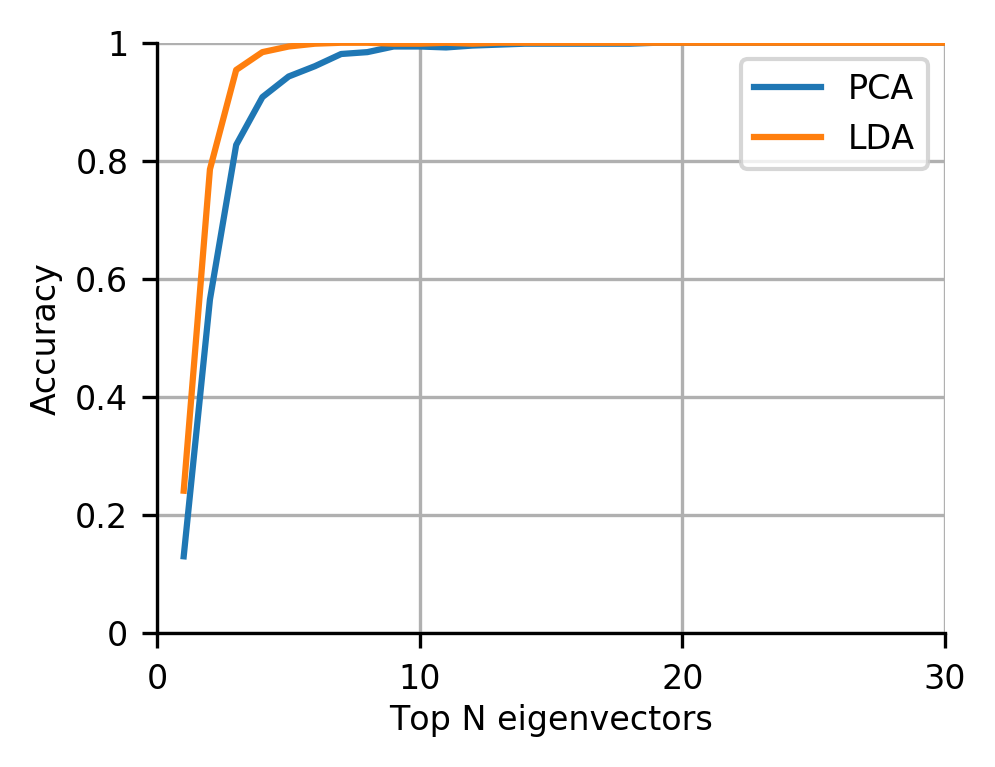

In [5]:
plt.figure(figsize = (3.2, 2.4), dpi = 300)
plt.axes().set_position([0.15, 0.15, 0.82, 0.82])
plt.axes().spines['top'].set_color('none')
plt.axes().spines['right'].set_color('none')

plt.xlabel('Top N eigenvectors', fontsize=8)
plt.axes().xaxis.set_label_coords(0.5,-0.12)
plt.xlim([0,30])
plt.xticks(np.arange(0,31,10))
plt.axes().set_xticklabels(labels = ["0","10","20","30"], fontsize=8)

plt.ylabel('Accuracy', fontsize=8)
plt.axes().yaxis.set_label_coords(-0.12,0.5)
plt.ylim([0, 1])
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
plt.axes().set_yticklabels(labels = [str(x) for x in [0, 0.2, 0.4, 0.6, 0.8, 1]], 
                           fontsize=8)
plt.axes().set_axisbelow(True)
plt.grid()

x = np.arange(1,31)
plt.plot(x,PCA_Accuracy[1:], label = "PCA")
plt.plot(x,LDA_Accuracy[1:], label = "LDA")

plt.legend(fontsize=8)
plt.savefig("FaceRecog.png")
plt.show()